In [89]:
import requests
import zipfile
from pathlib import Path


data_path = Path("data")
image_path = data_path / "images"
image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "data.zip", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/AgaMiko/pixel_character_generator/b9e28781b2815689c6361b350ab3603752b4b092/data.zip")
  print("Downloading TinyHero Dataset")
  f.write(request.content)

with zipfile.ZipFile(data_path / "data.zip", "r") as zip_ref:
  print("Extracting TinyHero Dataset")
  zip_ref.extractall(image_path)

Extracting TinyHero Dataset


In [90]:
dataset_path = image_path / "data"
dataset_path

PosixPath('data/images/data')

In [91]:
import os

def walk_thorugh_directory(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_thorugh_directory(image_path)

There are 1 directories and 0 images in 'data/images'.
There are 4 directories and 0 images in 'data/images/data'.
There are 0 directories and 912 images in 'data/images/data/0'.
There are 0 directories and 912 images in 'data/images/data/2'.
There are 0 directories and 912 images in 'data/images/data/1'.
There are 0 directories and 912 images in 'data/images/data/3'.


In [92]:
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.png"))
print(f"There are {len(image_path_list)} images.")

There are 3648 images.


In [93]:
image_path_list[:10]

[PosixPath('data/images/data/0/34.png'),
 PosixPath('data/images/data/0/494.png'),
 PosixPath('data/images/data/0/305.png'),
 PosixPath('data/images/data/0/547.png'),
 PosixPath('data/images/data/0/185.png'),
 PosixPath('data/images/data/0/90.png'),
 PosixPath('data/images/data/0/195.png'),
 PosixPath('data/images/data/0/137.png'),
 PosixPath('data/images/data/0/48.png'),
 PosixPath('data/images/data/0/760.png')]

Height 64
Width 64
Character 0


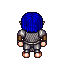

In [94]:
image = image_path_list[0]
img_character = image.parent.stem
img = Image.open(image)
print(f"Height {img.height}")
print(f"Width {img.width}")
print(f"Character {img_character}")
img


In [95]:
image

PosixPath('data/images/data/0/34.png')

In [96]:
name = image.stem
name

'34'

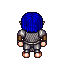

Height 64
Width 64
Character 34


In [97]:
def display_images(n_img: int, image_path_list: list):
  for i in range(n_img):
    if n_img > 20:
      print(f"Limiting the function to only work with 20 images.")
      n_img = 20
    image = image_path_list[i]
    img_character = image.stem
    img = Image.open(image)
    display(img)
    print(f"Height {img.height}")
    print(f"Width {img.width}")
    print(f"Character {img_character}")

display_images(1,
               image_path_list);

# **Turning Data into Tensor's**

* Turning Data into Tensor's using `ImageFolder`
* Applyinng Data Augmentation on our Dataset using `transforms`

In [98]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2

transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
    v2.RandomHorizontalFlip(0.1)
])

img_dataset = datasets.ImageFolder(root=dataset_path,
                                  transform=transform,
                                  target_transform=None)


img_dataset


Dataset ImageFolder
    Number of datapoints: 3648
    Root location: data/images/data
    StandardTransform
Transform: Compose(
                 ToTensor()
                 Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
                 RandomHorizontalFlip(p=0.1)
           )

In [99]:
import os
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

img_loader = DataLoader(dataset=img_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=NUM_WORKERS,
                        )

img_loader

In [100]:
len(img_dataset)

3648

In [101]:
len(img_loader)

57

# **Model 0 - Generating Pixel Art Images**

**Using Convulsional AutoEncoder**
 * the goal is to generate pixelart images
 * experimenting with different approaches to test and better understand the process
 * the TinyHero Dataset contains images that are *64x64* pixels


In [102]:
img_shape = img_dataset[0][0]
img_shape.shape

torch.Size([3, 64, 64])

In [103]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [1]:
from torch import nn
import torch.nn.functional as F

class TinyHero0(nn.Module):
  def __init__(self):
    super(TinyHero0, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(4, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    )

    self.decoder = nn.Sequential(
       nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1,output_padding=1),
       nn.ReLU(),
       nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
       nn.ReLU(),
       nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
       nn.ReLU(),
       nn.Conv2d(16, 3, 3, padding=1)
    )

  def forward(self, x):
    edge = self.sobel_edges(x)
    x_cat = torch.cat([x, edge], dim=1)
    encoded_x = self.encoder(x_cat)
    decoded_x = self.decoder(encoded_x)
    return decoded_x

  def sobel_edges(self, x):
    gx =F.conv2d(x, self.get_sobel_kernel('x').to(device), padding=1, groups=3)
    gy = F.conv2d(x, self.get_sobel_kernel('y').to(device), padding=1,groups=3)
    grad_mag = torch.sqrt(torch.pow(gx, 2) + torch.pow(gy, 2))
    edge = grad_mag.mean(dim=1, keepdim=True)
    return edge.to(device)

  def get_sobel_kernel(self, direction='x'):
    sobel_x = torch.tensor([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]], dtype=torch.float32)

    sobel_y = torch.tensor([[-1, -2, -1],
                            [0, 0, 0],
                            [1, 2, 1]], dtype=torch.float32)

    kernel = sobel_x if direction == 'x' else sobel_y
    kernel = kernel.repeat(3, 1, 1, 1)
    return kernel.to(device)



# Creating an instance of Model 0

TinyHero = TinyHero0().to(device)
TinyHero

NameError: name 'device' is not defined

# Setup the Loss Function and Optimizer

**Model 0:**
* will use `nn.MSELoss()` to calculate the loss of our model
* will use `torch.optim.Adam()` as Optimizer

**Model 1**
 * will use `L1Loss` function
 * will use Data Augmentation
  * `v2.RandomHorizontalFlip`


In [105]:
loss_fn = nn.SmoothL1Loss(beta=0.01)
optimizer = torch.optim.Adam(params=TinyHero0.parameters(), lr=1e-3)

In [106]:
X, _ = next(iter(img_loader))
print(f"X min: {X.min().item()}, max: {X.max().item()}")


X min: -1.0, max: 1.0


# Trains Step Function

In [107]:

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Adam):
  model.train()

  train_loss = 0

  for i, (X, _) in enumerate(data_loader):
    X = X.to(device)
    y_pred = model(X.to(device))
    loss = loss_fn(y_pred, X)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    if i % 50 == 0:
      print(f"Loss: {loss.item()}")
  train_loss = train_loss / len(data_loader)
  return train_loss





In [108]:
with torch.no_grad():
    for i, (X, _) in enumerate(img_loader):
        X = X.to(device)
        y_pred = TinyHero0(X)
        print(f"Output min: {y_pred.min().item()}, max: {y_pred.max().item()}")
        break


Output min: -0.010395625606179237, max: 0.04604599252343178


In [109]:
def train(model: torch.nn.Module,
          data_loader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Adam,
          epochs: int=5):

  from tqdm import tqdm
  train_loss_values = []
  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss = train_step(model=model,
                            data_loader=data_loader,
                            loss_fn=loss_fn,
                            optimizer=optimizer)
  train_loss_values.append(train_loss)
  print(f"Train loss: {train_loss}")
  return train_loss_values



In [129]:
EPOCHS = 250

from timeit import default_timer as timer

start_time = timer()
train_loss_values = train(model=TinyHero0,
                          data_loader=img_loader,
                          loss_fn=loss_fn,
                          optimizer=optimizer,
                          epochs=EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 0
-------
Loss: 0.02390780672430992
Loss: 0.025077244266867638


  0%|          | 1/250 [00:02<09:05,  2.19s/it]

Epoch: 1
-------
Loss: 0.02508477494120598


  1%|          | 2/250 [00:04<08:49,  2.14s/it]

Loss: 0.02479102462530136
Epoch: 2
-------
Loss: 0.025072138756513596
Loss: 0.02541058324277401


  1%|          | 3/250 [00:06<08:37,  2.10s/it]

Epoch: 3
-------
Loss: 0.026466939598321915
Loss: 0.02658165618777275


  2%|▏         | 4/250 [00:08<08:33,  2.09s/it]

Epoch: 4
-------
Loss: 0.024254372343420982
Loss: 0.02487681433558464


  2%|▏         | 5/250 [00:10<08:37,  2.11s/it]

Epoch: 5
-------
Loss: 0.02405104599893093
Loss: 0.02470817230641842


  2%|▏         | 6/250 [00:13<09:54,  2.44s/it]

Epoch: 6
-------
Loss: 0.025784291326999664
Loss: 0.02486521564424038


  3%|▎         | 7/250 [00:15<09:26,  2.33s/it]

Epoch: 7
-------
Loss: 0.02482309192419052


  3%|▎         | 8/250 [00:17<09:05,  2.25s/it]

Loss: 0.025182873010635376
Epoch: 8
-------
Loss: 0.024486802518367767


  4%|▎         | 9/250 [00:19<08:48,  2.19s/it]

Loss: 0.025481944903731346
Epoch: 9
-------
Loss: 0.02499651163816452
Loss: 0.024763500317931175


  4%|▍         | 10/250 [00:22<08:42,  2.18s/it]

Epoch: 10
-------
Loss: 0.026025420054793358
Loss: 0.023817628622055054


  4%|▍         | 11/250 [00:24<09:11,  2.31s/it]

Epoch: 11
-------
Loss: 0.02428167127072811
Loss: 0.025774415582418442


  5%|▍         | 12/250 [00:27<09:32,  2.41s/it]

Epoch: 12
-------
Loss: 0.024780675768852234
Loss: 0.02498326450586319


  5%|▌         | 13/250 [00:29<09:06,  2.30s/it]

Epoch: 13
-------
Loss: 0.02396448701620102
Loss: 0.026353370398283005


  6%|▌         | 14/250 [00:31<08:49,  2.25s/it]

Epoch: 14
-------
Loss: 0.02652015909552574
Loss: 0.02466776967048645


  6%|▌         | 15/250 [00:33<08:46,  2.24s/it]

Epoch: 15
-------
Loss: 0.024769416078925133


  6%|▋         | 16/250 [00:35<08:34,  2.20s/it]

Loss: 0.02589695155620575
Epoch: 16
-------
Loss: 0.02474418841302395
Loss: 0.023309094831347466


  7%|▋         | 17/250 [00:38<09:41,  2.50s/it]

Epoch: 17
-------
Loss: 0.02450885996222496
Loss: 0.023354386910796165


  7%|▋         | 18/250 [00:41<09:09,  2.37s/it]

Epoch: 18
-------
Loss: 0.025844939053058624
Loss: 0.024108532816171646


  8%|▊         | 19/250 [00:43<08:46,  2.28s/it]

Epoch: 19
-------
Loss: 0.025207368656992912
Loss: 0.02392996847629547


  8%|▊         | 20/250 [00:45<08:30,  2.22s/it]

Epoch: 20
-------
Loss: 0.02400987409055233
Loss: 0.024912815541028976


  8%|▊         | 21/250 [00:47<08:21,  2.19s/it]

Epoch: 21
-------
Loss: 0.02367764338850975
Loss: 0.02454729937016964


  9%|▉         | 22/250 [00:49<08:32,  2.25s/it]

Epoch: 22
-------
Loss: 0.025370564311742783
Loss: 0.02575094811618328


  9%|▉         | 23/250 [00:52<09:08,  2.41s/it]

Epoch: 23
-------
Loss: 0.024229925125837326


 10%|▉         | 24/250 [00:54<08:42,  2.31s/it]

Loss: 0.024212032556533813
Epoch: 24
-------
Loss: 0.024809546768665314
Loss: 0.02470361441373825


 10%|█         | 25/250 [00:56<08:23,  2.24s/it]

Epoch: 25
-------
Loss: 0.023494398221373558
Loss: 0.024227943271398544


 10%|█         | 26/250 [00:58<08:11,  2.20s/it]

Epoch: 26
-------
Loss: 0.025405172258615494


 11%|█         | 27/250 [01:00<08:04,  2.17s/it]

Loss: 0.023845762014389038
Epoch: 27
-------
Loss: 0.024168476462364197
Loss: 0.024113696068525314


 11%|█         | 28/250 [01:03<08:51,  2.39s/it]

Epoch: 28
-------
Loss: 0.02391570806503296
Loss: 0.02382657490670681


 12%|█▏        | 29/250 [01:06<08:52,  2.41s/it]

Epoch: 29
-------
Loss: 0.024201516062021255
Loss: 0.024666398763656616


 12%|█▏        | 30/250 [01:08<08:28,  2.31s/it]

Epoch: 30
-------
Loss: 0.024727841839194298


 12%|█▏        | 31/250 [01:10<08:14,  2.26s/it]

Loss: 0.024454697966575623
Epoch: 31
-------
Loss: 0.022560348734259605
Loss: 0.02250572107732296


 13%|█▎        | 32/250 [01:12<08:01,  2.21s/it]

Epoch: 32
-------
Loss: 0.0238938145339489
Loss: 0.02475149929523468


 13%|█▎        | 33/250 [01:14<07:50,  2.17s/it]

Epoch: 33
-------
Loss: 0.024371977895498276
Loss: 0.023211058229207993


 14%|█▎        | 34/250 [01:17<08:50,  2.45s/it]

Epoch: 34
-------
Loss: 0.02381894364953041
Loss: 0.02396303229033947


 14%|█▍        | 35/250 [01:19<08:23,  2.34s/it]

Epoch: 35
-------
Loss: 0.02448762208223343
Loss: 0.02234267257153988


 14%|█▍        | 36/250 [01:21<08:09,  2.29s/it]

Epoch: 36
-------
Loss: 0.02360251545906067
Loss: 0.023339450359344482


 15%|█▍        | 37/250 [01:24<07:54,  2.23s/it]

Epoch: 37
-------
Loss: 0.024110784754157066
Loss: 0.025456508621573448


 15%|█▌        | 38/250 [01:26<07:43,  2.19s/it]

Epoch: 38
-------
Loss: 0.02243153378367424
Loss: 0.02337656542658806


 16%|█▌        | 39/250 [01:28<08:04,  2.30s/it]

Epoch: 39
-------
Loss: 0.023803232237696648


 16%|█▌        | 40/250 [01:31<08:21,  2.39s/it]

Loss: 0.023456301540136337
Epoch: 40
-------
Loss: 0.02432997152209282
Loss: 0.026272375136613846


 16%|█▋        | 41/250 [01:33<08:05,  2.32s/it]

Epoch: 41
-------
Loss: 0.02443493716418743
Loss: 0.023118775337934494


 17%|█▋        | 42/250 [01:35<07:48,  2.25s/it]

Epoch: 42
-------
Loss: 0.023328933864831924
Loss: 0.023119134828448296


 17%|█▋        | 43/250 [01:37<07:33,  2.19s/it]

Epoch: 43
-------
Loss: 0.022684618830680847
Loss: 0.02432963252067566


 18%|█▊        | 44/250 [01:39<07:23,  2.15s/it]

Epoch: 44
-------
Loss: 0.024485338479280472
Loss: 0.022969882935285568


 18%|█▊        | 45/250 [01:42<08:10,  2.39s/it]

Epoch: 45
-------
Loss: 0.02361661195755005
Loss: 0.0222158245742321


 18%|█▊        | 46/250 [01:44<07:59,  2.35s/it]

Epoch: 46
-------
Loss: 0.023087522014975548


 19%|█▉        | 47/250 [01:46<07:39,  2.26s/it]

Loss: 0.023433398455381393
Epoch: 47
-------
Loss: 0.02367168664932251
Loss: 0.023113980889320374


 19%|█▉        | 48/250 [01:48<07:24,  2.20s/it]

Epoch: 48
-------
Loss: 0.024409055709838867
Loss: 0.022314827889204025


 20%|█▉        | 49/250 [01:51<07:12,  2.15s/it]

Epoch: 49
-------
Loss: 0.02363947592675686
Loss: 0.02491942048072815


 20%|██        | 50/250 [01:53<07:10,  2.15s/it]

Epoch: 50
-------
Loss: 0.022363901138305664
Loss: 0.02331887185573578


 20%|██        | 51/250 [01:56<08:00,  2.42s/it]

Epoch: 51
-------
Loss: 0.023350734263658524
Loss: 0.023212697356939316


 21%|██        | 52/250 [01:58<07:40,  2.32s/it]

Epoch: 52
-------
Loss: 0.02310749515891075
Loss: 0.023161595687270164


 21%|██        | 53/250 [02:00<07:21,  2.24s/it]

Epoch: 53
-------
Loss: 0.02448173612356186
Loss: 0.02347630262374878


 22%|██▏       | 54/250 [02:02<07:09,  2.19s/it]

Epoch: 54
-------
Loss: 0.02319941483438015
Loss: 0.02294103428721428


 22%|██▏       | 55/250 [02:04<07:05,  2.18s/it]

Epoch: 55
-------
Loss: 0.02150137536227703
Loss: 0.02497876062989235


 22%|██▏       | 56/250 [02:07<07:37,  2.36s/it]

Epoch: 56
-------
Loss: 0.022971436381340027
Loss: 0.023169657215476036


 23%|██▎       | 57/250 [02:09<07:44,  2.41s/it]

Epoch: 57
-------
Loss: 0.022383399307727814


 23%|██▎       | 58/250 [02:11<07:23,  2.31s/it]

Loss: 0.0223827101290226
Epoch: 58
-------
Loss: 0.02289445698261261


 24%|██▎       | 59/250 [02:14<07:08,  2.24s/it]

Loss: 0.0232418030500412
Epoch: 59
-------
Loss: 0.02324553206562996
Loss: 0.022888030856847763


 24%|██▍       | 60/250 [02:16<06:57,  2.20s/it]

Epoch: 60
-------
Loss: 0.022983742877840996
Loss: 0.02476816438138485


 24%|██▍       | 61/250 [02:18<06:49,  2.17s/it]

Epoch: 61
-------
Loss: 0.02351640723645687
Loss: 0.023198198527097702


 25%|██▍       | 62/250 [02:21<07:46,  2.48s/it]

Epoch: 62
-------
Loss: 0.022526031360030174
Loss: 0.02283763512969017


 25%|██▌       | 63/250 [02:23<07:22,  2.37s/it]

Epoch: 63
-------
Loss: 0.021814903244376183
Loss: 0.022076498717069626


 26%|██▌       | 64/250 [02:25<07:00,  2.26s/it]

Epoch: 64
-------
Loss: 0.023425808176398277
Loss: 0.022183960303664207


 26%|██▌       | 65/250 [02:27<06:45,  2.19s/it]

Epoch: 65
-------
Loss: 0.022761356085538864
Loss: 0.022678744047880173


 26%|██▋       | 66/250 [02:29<06:37,  2.16s/it]

Epoch: 66
-------
Loss: 0.023102983832359314
Loss: 0.022945992648601532


 27%|██▋       | 67/250 [02:31<06:38,  2.18s/it]

Epoch: 67
-------
Loss: 0.023328635841608047
Loss: 0.023985568434000015


 27%|██▋       | 68/250 [02:35<07:28,  2.46s/it]

Epoch: 68
-------
Loss: 0.022681057453155518
Loss: 0.02224252000451088


 28%|██▊       | 69/250 [02:37<07:07,  2.36s/it]

Epoch: 69
-------
Loss: 0.022766491398215294
Loss: 0.023376306518912315


 28%|██▊       | 70/250 [02:39<06:48,  2.27s/it]

Epoch: 70
-------
Loss: 0.02210894227027893
Loss: 0.022336943075060844


 28%|██▊       | 71/250 [02:41<06:37,  2.22s/it]

Epoch: 71
-------
Loss: 0.022730058059096336
Loss: 0.022448793053627014


 29%|██▉       | 72/250 [02:43<06:25,  2.16s/it]

Epoch: 72
-------
Loss: 0.022492092102766037
Loss: 0.022217778488993645


 29%|██▉       | 73/250 [02:46<06:56,  2.35s/it]

Epoch: 73
-------
Loss: 0.022479619830846786
Loss: 0.022328410297632217


 30%|██▉       | 74/250 [02:48<06:55,  2.36s/it]

Epoch: 74
-------
Loss: 0.021240275353193283
Loss: 0.02316935360431671


 30%|███       | 75/250 [02:50<06:36,  2.26s/it]

Epoch: 75
-------
Loss: 0.022050974890589714
Loss: 0.021897241473197937


 30%|███       | 76/250 [02:52<06:23,  2.20s/it]

Epoch: 76
-------
Loss: 0.023198425769805908
Loss: 0.02291111648082733


 31%|███       | 77/250 [02:54<06:12,  2.15s/it]

Epoch: 77
-------
Loss: 0.02153301239013672
Loss: 0.023833032697439194


 31%|███       | 78/250 [02:56<06:04,  2.12s/it]

Epoch: 78
-------
Loss: 0.0223705917596817
Loss: 0.02311367355287075


 32%|███▏      | 79/250 [02:59<06:40,  2.34s/it]

Epoch: 79
-------
Loss: 0.022781258448958397


 32%|███▏      | 80/250 [03:01<06:33,  2.32s/it]

Loss: 0.022289130836725235
Epoch: 80
-------
Loss: 0.02320617437362671


 32%|███▏      | 81/250 [03:03<06:20,  2.25s/it]

Loss: 0.022128140553832054
Epoch: 81
-------
Loss: 0.022974183782935143
Loss: 0.02235453389585018


 33%|███▎      | 82/250 [03:06<06:16,  2.24s/it]

Epoch: 82
-------
Loss: 0.02168196067214012
Loss: 0.023249417543411255


 33%|███▎      | 83/250 [03:08<06:04,  2.18s/it]

Epoch: 83
-------
Loss: 0.02210121974349022
Loss: 0.02364732325077057


 34%|███▎      | 84/250 [03:10<06:02,  2.18s/it]

Epoch: 84
-------
Loss: 0.022286763414740562
Loss: 0.022126294672489166


 34%|███▍      | 85/250 [03:13<06:40,  2.43s/it]

Epoch: 85
-------
Loss: 0.021715831011533737
Loss: 0.02173592522740364


 34%|███▍      | 86/250 [03:15<06:21,  2.32s/it]

Epoch: 86
-------
Loss: 0.022465137764811516
Loss: 0.023500677198171616


 35%|███▍      | 87/250 [03:17<06:06,  2.25s/it]

Epoch: 87
-------
Loss: 0.02284865826368332


 35%|███▌      | 88/250 [03:19<05:55,  2.20s/it]

Loss: 0.022460516542196274
Epoch: 88
-------
Loss: 0.021336328238248825


 36%|███▌      | 89/250 [03:21<05:46,  2.15s/it]

Loss: 0.021350210532546043
Epoch: 89
-------
Loss: 0.021769581362605095
Loss: 0.0221098642796278


 36%|███▌      | 90/250 [03:23<05:53,  2.21s/it]

Epoch: 90
-------
Loss: 0.021830573678016663


 36%|███▋      | 91/250 [03:26<06:19,  2.39s/it]

Loss: 0.022879719734191895
Epoch: 91
-------
Loss: 0.021924421191215515
Loss: 0.022161131724715233


 37%|███▋      | 92/250 [03:28<06:00,  2.28s/it]

Epoch: 92
-------
Loss: 0.02151617966592312
Loss: 0.023982204496860504


 37%|███▋      | 93/250 [03:30<05:45,  2.20s/it]

Epoch: 93
-------
Loss: 0.02390946075320244
Loss: 0.022578096017241478


 38%|███▊      | 94/250 [03:32<05:36,  2.16s/it]

Epoch: 94
-------
Loss: 0.023038595914840698
Loss: 0.021691828966140747


 38%|███▊      | 95/250 [03:34<05:31,  2.14s/it]

Epoch: 95
-------
Loss: 0.023021696135401726
Loss: 0.02215149812400341


 38%|███▊      | 96/250 [03:37<06:06,  2.38s/it]

Epoch: 96
-------
Loss: 0.021418970078229904


 39%|███▉      | 97/250 [03:40<06:02,  2.37s/it]

Loss: 0.02346840314567089
Epoch: 97
-------
Loss: 0.02135792374610901
Loss: 0.021271582692861557


 39%|███▉      | 98/250 [03:42<05:46,  2.28s/it]

Epoch: 98
-------
Loss: 0.023448627442121506
Loss: 0.02213822305202484


 40%|███▉      | 99/250 [03:44<05:36,  2.23s/it]

Epoch: 99
-------
Loss: 0.02262159436941147
Loss: 0.0210857056081295


 40%|████      | 100/250 [03:46<05:27,  2.18s/it]

Epoch: 100
-------
Loss: 0.02125323936343193
Loss: 0.021157121285796165


 40%|████      | 101/250 [03:48<05:19,  2.14s/it]

Epoch: 101
-------
Loss: 0.021979454904794693
Loss: 0.02256222441792488


 41%|████      | 102/250 [03:51<06:00,  2.43s/it]

Epoch: 102
-------
Loss: 0.02202337607741356


 41%|████      | 103/250 [03:53<05:42,  2.33s/it]

Loss: 0.020877480506896973
Epoch: 103
-------
Loss: 0.02112009935081005
Loss: 0.021957173943519592


 42%|████▏     | 104/250 [03:55<05:28,  2.25s/it]

Epoch: 104
-------
Loss: 0.02286791056394577
Loss: 0.02207443118095398


 42%|████▏     | 105/250 [03:57<05:20,  2.21s/it]

Epoch: 105
-------
Loss: 0.02237488329410553
Loss: 0.02291182242333889


 42%|████▏     | 106/250 [04:00<05:12,  2.17s/it]

Epoch: 106
-------
Loss: 0.022845793515443802
Loss: 0.021883301436901093


 43%|████▎     | 107/250 [04:02<05:22,  2.26s/it]

Epoch: 107
-------
Loss: 0.020262449979782104


 43%|████▎     | 108/250 [04:05<05:43,  2.42s/it]

Loss: 0.021129559725522995
Epoch: 108
-------
Loss: 0.023407284170389175
Loss: 0.021769573912024498


 44%|████▎     | 109/250 [04:07<05:30,  2.34s/it]

Epoch: 109
-------
Loss: 0.022237978875637054
Loss: 0.02076129987835884


 44%|████▍     | 110/250 [04:09<05:15,  2.25s/it]

Epoch: 110
-------
Loss: 0.021782677620649338
Loss: 0.021387532353401184


 44%|████▍     | 111/250 [04:11<05:04,  2.19s/it]

Epoch: 111
-------
Loss: 0.021835803985595703
Loss: 0.022341977804899216


 45%|████▍     | 112/250 [04:13<04:56,  2.15s/it]

Epoch: 112
-------
Loss: 0.020955052226781845
Loss: 0.021965470165014267


 45%|████▌     | 113/250 [04:16<05:17,  2.31s/it]

Epoch: 113
-------
Loss: 0.021617617458105087
Loss: 0.021831955760717392


 46%|████▌     | 114/250 [04:18<05:20,  2.35s/it]

Epoch: 114
-------
Loss: 0.021530792117118835
Loss: 0.020451191812753677


 46%|████▌     | 115/250 [04:20<05:07,  2.28s/it]

Epoch: 115
-------
Loss: 0.019924221560359
Loss: 0.0211234912276268


 46%|████▋     | 116/250 [04:22<04:56,  2.21s/it]

Epoch: 116
-------
Loss: 0.021939218044281006


 47%|████▋     | 117/250 [04:24<04:46,  2.16s/it]

Loss: 0.020836954936385155
Epoch: 117
-------
Loss: 0.022516947239637375
Loss: 0.02030133083462715


 47%|████▋     | 118/250 [04:26<04:40,  2.12s/it]

Epoch: 118
-------
Loss: 0.020497433841228485
Loss: 0.02157052420079708


 48%|████▊     | 119/250 [04:30<05:17,  2.42s/it]

Epoch: 119
-------
Loss: 0.022243019193410873
Loss: 0.02217581868171692


 48%|████▊     | 120/250 [04:32<05:02,  2.33s/it]

Epoch: 120
-------
Loss: 0.02139003574848175


 48%|████▊     | 121/250 [04:34<04:49,  2.25s/it]

Loss: 0.02010270208120346
Epoch: 121
-------
Loss: 0.02149764820933342
Loss: 0.022121723741292953


 49%|████▉     | 122/250 [04:36<04:45,  2.23s/it]

Epoch: 122
-------
Loss: 0.022243410348892212
Loss: 0.021196922287344933


 49%|████▉     | 123/250 [04:38<04:35,  2.17s/it]

Epoch: 123
-------
Loss: 0.021462664008140564
Loss: 0.01997968554496765


 50%|████▉     | 124/250 [04:40<04:35,  2.18s/it]

Epoch: 124
-------
Loss: 0.02050003968179226


 50%|█████     | 125/250 [04:43<05:00,  2.41s/it]

Loss: 0.020806126296520233
Epoch: 125
-------
Loss: 0.019791381433606148
Loss: 0.02180207334458828


 50%|█████     | 126/250 [04:45<04:46,  2.31s/it]

Epoch: 126
-------
Loss: 0.020920773968100548
Loss: 0.02100694738328457


 51%|█████     | 127/250 [04:47<04:34,  2.23s/it]

Epoch: 127
-------
Loss: 0.019757144153118134
Loss: 0.020621564239263535


 51%|█████     | 128/250 [04:49<04:26,  2.19s/it]

Epoch: 128
-------
Loss: 0.021026132628321648
Loss: 0.021339740604162216


 52%|█████▏    | 129/250 [04:51<04:20,  2.15s/it]

Epoch: 129
-------
Loss: 0.022190213203430176
Loss: 0.02141532301902771


 52%|█████▏    | 130/250 [04:54<04:38,  2.32s/it]

Epoch: 130
-------
Loss: 0.02016235701739788
Loss: 0.02058599144220352


 52%|█████▏    | 131/250 [04:57<04:42,  2.37s/it]

Epoch: 131
-------
Loss: 0.022364413365721703


 53%|█████▎    | 132/250 [04:59<04:26,  2.26s/it]

Loss: 0.020886247977614403
Epoch: 132
-------
Loss: 0.021095475181937218
Loss: 0.020884796977043152


 53%|█████▎    | 133/250 [05:01<04:16,  2.19s/it]

Epoch: 133
-------
Loss: 0.021429238840937614
Loss: 0.02228235825896263


 54%|█████▎    | 134/250 [05:03<04:10,  2.16s/it]

Epoch: 134
-------
Loss: 0.021658942103385925


 54%|█████▍    | 135/250 [05:05<04:05,  2.13s/it]

Loss: 0.021171987056732178
Epoch: 135
-------
Loss: 0.021079357713460922
Loss: 0.02081703208386898


 54%|█████▍    | 136/250 [05:08<04:36,  2.42s/it]

Epoch: 136
-------
Loss: 0.020979193970561028
Loss: 0.022105364128947258


 55%|█████▍    | 137/250 [05:10<04:26,  2.36s/it]

Epoch: 137
-------
Loss: 0.02024116739630699
Loss: 0.02099621668457985


 55%|█████▌    | 138/250 [05:12<04:13,  2.27s/it]

Epoch: 138
-------
Loss: 0.020774511620402336
Loss: 0.021092485636472702


 56%|█████▌    | 139/250 [05:14<04:03,  2.20s/it]

Epoch: 139
-------
Loss: 0.021460924297571182


 56%|█████▌    | 140/250 [05:16<03:56,  2.15s/it]

Loss: 0.02233460359275341
Epoch: 140
-------
Loss: 0.021189888939261436
Loss: 0.022065550088882446


 56%|█████▋    | 141/250 [05:18<03:53,  2.14s/it]

Epoch: 141
-------
Loss: 0.02000265195965767
Loss: 0.02129913866519928


 57%|█████▋    | 142/250 [05:22<04:23,  2.44s/it]

Epoch: 142
-------
Loss: 0.021411960944533348


 57%|█████▋    | 143/250 [05:24<04:10,  2.34s/it]

Loss: 0.018790055066347122
Epoch: 143
-------
Loss: 0.0212737824767828
Loss: 0.01970551162958145


 58%|█████▊    | 144/250 [05:26<03:58,  2.25s/it]

Epoch: 144
-------
Loss: 0.020468877628445625


 58%|█████▊    | 145/250 [05:28<03:49,  2.18s/it]

Loss: 0.02132995054125786
Epoch: 145
-------
Loss: 0.0194842629134655
Loss: 0.020525045692920685


 58%|█████▊    | 146/250 [05:30<03:43,  2.15s/it]

Epoch: 146
-------
Loss: 0.021285902708768845
Loss: 0.02013770118355751


 59%|█████▉    | 147/250 [05:32<03:54,  2.27s/it]

Epoch: 147
-------
Loss: 0.019834715873003006
Loss: 0.02227119170129299


 59%|█████▉    | 148/250 [05:35<04:03,  2.39s/it]

Epoch: 148
-------
Loss: 0.02203991264104843


 60%|█████▉    | 149/250 [05:37<03:53,  2.31s/it]

Loss: 0.020827367901802063
Epoch: 149
-------
Loss: 0.019762039184570312
Loss: 0.022958261892199516


 60%|██████    | 150/250 [05:39<03:44,  2.24s/it]

Epoch: 150
-------
Loss: 0.02106485329568386
Loss: 0.020610572770237923


 60%|██████    | 151/250 [05:41<03:37,  2.20s/it]

Epoch: 151
-------
Loss: 0.02124779485166073
Loss: 0.021106740459799767


 61%|██████    | 152/250 [05:43<03:33,  2.18s/it]

Epoch: 152
-------
Loss: 0.021012526005506516
Loss: 0.02063114009797573


 61%|██████    | 153/250 [05:46<03:53,  2.40s/it]

Epoch: 153
-------
Loss: 0.020573511719703674


 62%|██████▏   | 154/250 [05:49<03:44,  2.34s/it]

Loss: 0.02116292715072632
Epoch: 154
-------
Loss: 0.020419735461473465
Loss: 0.020671289414167404


 62%|██████▏   | 155/250 [05:51<03:33,  2.25s/it]

Epoch: 155
-------
Loss: 0.021972626447677612
Loss: 0.02056298404932022


 62%|██████▏   | 156/250 [05:53<03:28,  2.22s/it]

Epoch: 156
-------
Loss: 0.021544579416513443


 63%|██████▎   | 157/250 [05:55<03:23,  2.19s/it]

Loss: 0.021168913692235947
Epoch: 157
-------
Loss: 0.01989220827817917
Loss: 0.021729018539190292


 63%|██████▎   | 158/250 [05:57<03:20,  2.18s/it]

Epoch: 158
-------
Loss: 0.020153654739260674
Loss: 0.020782705396413803


 64%|██████▎   | 159/250 [06:00<03:39,  2.42s/it]

Epoch: 159
-------
Loss: 0.021009426563978195
Loss: 0.020471464842557907


 64%|██████▍   | 160/250 [06:02<03:28,  2.31s/it]

Epoch: 160
-------
Loss: 0.01980295032262802
Loss: 0.02031841315329075


 64%|██████▍   | 161/250 [06:04<03:18,  2.23s/it]

Epoch: 161
-------
Loss: 0.019969111308455467
Loss: 0.020145053043961525


 65%|██████▍   | 162/250 [06:06<03:12,  2.19s/it]

Epoch: 162
-------
Loss: 0.02162965200841427
Loss: 0.020897574722766876


 65%|██████▌   | 163/250 [06:08<03:08,  2.17s/it]

Epoch: 163
-------
Loss: 0.019416091963648796
Loss: 0.020751046016812325


 66%|██████▌   | 164/250 [06:11<03:17,  2.29s/it]

Epoch: 164
-------
Loss: 0.02014937810599804


 66%|██████▌   | 165/250 [06:13<03:19,  2.35s/it]

Loss: 0.020801877602934837
Epoch: 165
-------
Loss: 0.021373562514781952


 66%|██████▋   | 166/250 [06:15<03:09,  2.26s/it]

Loss: 0.020382583141326904
Epoch: 166
-------
Loss: 0.0196536835283041
Loss: 0.019829031080007553


 67%|██████▋   | 167/250 [06:17<03:03,  2.21s/it]

Epoch: 167
-------
Loss: 0.02009863778948784
Loss: 0.019582293927669525


 67%|██████▋   | 168/250 [06:20<02:58,  2.18s/it]

Epoch: 168
-------
Loss: 0.01990511640906334
Loss: 0.020182553678750992


 68%|██████▊   | 169/250 [06:22<02:54,  2.15s/it]

Epoch: 169
-------
Loss: 0.020565692335367203
Loss: 0.020454932004213333


 68%|██████▊   | 170/250 [06:25<03:15,  2.45s/it]

Epoch: 170
-------
Loss: 0.020609913393855095


 68%|██████▊   | 171/250 [06:27<03:04,  2.33s/it]

Loss: 0.01970159076154232
Epoch: 171
-------
Loss: 0.018981188535690308
Loss: 0.020720142871141434


 69%|██████▉   | 172/250 [06:29<02:56,  2.26s/it]

Epoch: 172
-------
Loss: 0.02024613879621029


 69%|██████▉   | 173/250 [06:31<02:50,  2.22s/it]

Loss: 0.020641887560486794
Epoch: 173
-------
Loss: 0.019661858677864075
Loss: 0.02063135802745819


 70%|██████▉   | 174/250 [06:33<02:45,  2.17s/it]

Epoch: 174
-------
Loss: 0.019617455080151558
Loss: 0.020754823461174965


 70%|███████   | 175/250 [06:36<02:50,  2.27s/it]

Epoch: 175
-------
Loss: 0.020840391516685486
Loss: 0.020113445818424225


 70%|███████   | 176/250 [06:38<02:59,  2.42s/it]

Epoch: 176
-------
Loss: 0.019848879426717758


 71%|███████   | 177/250 [06:40<02:48,  2.31s/it]

Loss: 0.019531089812517166
Epoch: 177
-------
Loss: 0.021168287843465805
Loss: 0.02043577842414379


 71%|███████   | 178/250 [06:43<02:41,  2.25s/it]

Epoch: 178
-------
Loss: 0.01909538544714451
Loss: 0.018915528431534767


 72%|███████▏  | 179/250 [06:45<02:35,  2.19s/it]

Epoch: 179
-------
Loss: 0.020700788125395775


 72%|███████▏  | 180/250 [06:47<02:30,  2.15s/it]

Loss: 0.02021859958767891
Epoch: 180
-------
Loss: 0.019927922636270523
Loss: 0.019896818324923515


 72%|███████▏  | 181/250 [06:50<02:44,  2.38s/it]

Epoch: 181
-------
Loss: 0.020700639113783836
Loss: 0.01991632580757141


 73%|███████▎  | 182/250 [06:52<02:39,  2.35s/it]

Epoch: 182
-------
Loss: 0.019364506006240845
Loss: 0.020969953387975693


 73%|███████▎  | 183/250 [06:54<02:32,  2.28s/it]

Epoch: 183
-------
Loss: 0.019318630918860435


 74%|███████▎  | 184/250 [06:56<02:25,  2.21s/it]

Loss: 0.020109249278903008
Epoch: 184
-------
Loss: 0.020922182127833366
Loss: 0.0201917365193367


 74%|███████▍  | 185/250 [06:58<02:21,  2.17s/it]

Epoch: 185
-------
Loss: 0.019167883321642876
Loss: 0.021538978442549706


 74%|███████▍  | 186/250 [07:00<02:17,  2.15s/it]

Epoch: 186
-------
Loss: 0.019082847982645035
Loss: 0.02102408930659294


 75%|███████▍  | 187/250 [07:03<02:34,  2.46s/it]

Epoch: 187
-------
Loss: 0.020217228680849075
Loss: 0.01943536102771759


 75%|███████▌  | 188/250 [07:06<02:26,  2.36s/it]

Epoch: 188
-------
Loss: 0.019279977306723595
Loss: 0.019933782517910004


 76%|███████▌  | 189/250 [07:08<02:18,  2.28s/it]

Epoch: 189
-------
Loss: 0.020664114505052567
Loss: 0.019318312406539917


 76%|███████▌  | 190/250 [07:10<02:14,  2.23s/it]

Epoch: 190
-------
Loss: 0.02018299698829651
Loss: 0.021206695586442947


 76%|███████▋  | 191/250 [07:12<02:08,  2.18s/it]

Epoch: 191
-------
Loss: 0.019885042682290077
Loss: 0.020581547170877457


 77%|███████▋  | 192/250 [07:14<02:10,  2.25s/it]

Epoch: 192
-------
Loss: 0.019707713276147842
Loss: 0.019364789128303528


 77%|███████▋  | 193/250 [07:17<02:16,  2.39s/it]

Epoch: 193
-------
Loss: 0.018930912017822266


 78%|███████▊  | 194/250 [07:19<02:08,  2.30s/it]

Loss: 0.019976405426859856
Epoch: 194
-------
Loss: 0.018866021186113358
Loss: 0.018331268802285194


 78%|███████▊  | 195/250 [07:21<02:02,  2.23s/it]

Epoch: 195
-------
Loss: 0.018921036273241043
Loss: 0.019286394119262695


 78%|███████▊  | 196/250 [07:23<01:57,  2.18s/it]

Epoch: 196
-------
Loss: 0.018202412873506546


 79%|███████▉  | 197/250 [07:25<01:53,  2.13s/it]

Loss: 0.019659124314785004
Epoch: 197
-------
Loss: 0.020830079913139343
Loss: 0.02117842435836792


 79%|███████▉  | 198/250 [07:28<02:00,  2.32s/it]

Epoch: 198
-------
Loss: 0.01969492994248867
Loss: 0.020497333258390427


 80%|███████▉  | 199/250 [07:30<01:59,  2.34s/it]

Epoch: 199
-------
Loss: 0.01986127905547619
Loss: 0.0200226791203022


 80%|████████  | 200/250 [07:32<01:53,  2.26s/it]

Epoch: 200
-------
Loss: 0.019514746963977814
Loss: 0.01909838244318962


 80%|████████  | 201/250 [07:35<01:48,  2.21s/it]

Epoch: 201
-------
Loss: 0.02021283283829689
Loss: 0.01956731453537941


 81%|████████  | 202/250 [07:37<01:44,  2.17s/it]

Epoch: 202
-------
Loss: 0.018039604648947716
Loss: 0.01908390037715435


 81%|████████  | 203/250 [07:39<01:40,  2.14s/it]

Epoch: 203
-------
Loss: 0.020535394549369812
Loss: 0.019791651517152786


 82%|████████▏ | 204/250 [07:42<01:53,  2.47s/it]

Epoch: 204
-------
Loss: 0.01908968761563301
Loss: 0.02136678621172905


 82%|████████▏ | 205/250 [07:44<01:46,  2.36s/it]

Epoch: 205
-------
Loss: 0.020016055554151535
Loss: 0.01977292262017727


 82%|████████▏ | 206/250 [07:46<01:39,  2.27s/it]

Epoch: 206
-------
Loss: 0.019268924370408058
Loss: 0.01929769292473793


 83%|████████▎ | 207/250 [07:48<01:34,  2.20s/it]

Epoch: 207
-------
Loss: 0.01870519295334816
Loss: 0.020267492160201073


 83%|████████▎ | 208/250 [07:50<01:30,  2.16s/it]

Epoch: 208
-------
Loss: 0.020731246098876
Loss: 0.01920325495302677


 84%|████████▎ | 209/250 [07:52<01:29,  2.19s/it]

Epoch: 209
-------
Loss: 0.01859302446246147


 84%|████████▍ | 210/250 [07:55<01:36,  2.41s/it]

Loss: 0.02082306146621704
Epoch: 210
-------
Loss: 0.019301962107419968
Loss: 0.019433878362178802


 84%|████████▍ | 211/250 [07:57<01:29,  2.30s/it]

Epoch: 211
-------
Loss: 0.018814923241734505


 85%|████████▍ | 212/250 [07:59<01:24,  2.22s/it]

Loss: 0.019664723426103592
Epoch: 212
-------
Loss: 0.01875109225511551
Loss: 0.020886287093162537


 85%|████████▌ | 213/250 [08:01<01:20,  2.17s/it]

Epoch: 213
-------
Loss: 0.01863422617316246


 86%|████████▌ | 214/250 [08:04<01:16,  2.14s/it]

Loss: 0.019945096224546432
Epoch: 214
-------
Loss: 0.019020237028598785
Loss: 0.01944592408835888


 86%|████████▌ | 215/250 [08:06<01:19,  2.28s/it]

Epoch: 215
-------
Loss: 0.020521771162748337
Loss: 0.02065558172762394


 86%|████████▋ | 216/250 [08:09<01:20,  2.36s/it]

Epoch: 216
-------
Loss: 0.019553886726498604


 87%|████████▋ | 217/250 [08:11<01:15,  2.29s/it]

Loss: 0.01930377632379532
Epoch: 217
-------
Loss: 0.019531836733222008
Loss: 0.019947703927755356


 87%|████████▋ | 218/250 [08:13<01:10,  2.20s/it]

Epoch: 218
-------
Loss: 0.02066146768629551


 88%|████████▊ | 219/250 [08:15<01:06,  2.15s/it]

Loss: 0.02078995481133461
Epoch: 219
-------
Loss: 0.019791996106505394
Loss: 0.018658123910427094


 88%|████████▊ | 220/250 [08:17<01:03,  2.13s/it]

Epoch: 220
-------
Loss: 0.018399745225906372
Loss: 0.018147539347410202


 88%|████████▊ | 221/250 [08:20<01:08,  2.37s/it]

Epoch: 221
-------
Loss: 0.020087899640202522
Loss: 0.02045832760632038


 89%|████████▉ | 222/250 [08:22<01:05,  2.33s/it]

Epoch: 222
-------
Loss: 0.019200418144464493


 89%|████████▉ | 223/250 [08:24<01:00,  2.23s/it]

Loss: 0.019527804106473923
Epoch: 223
-------
Loss: 0.019576488062739372
Loss: 0.018346160650253296


 90%|████████▉ | 224/250 [08:26<00:56,  2.16s/it]

Epoch: 224
-------
Loss: 0.01857421174645424
Loss: 0.019718268886208534


 90%|█████████ | 225/250 [08:28<00:52,  2.11s/it]

Epoch: 225
-------
Loss: 0.018970077857375145
Loss: 0.01809968426823616


 90%|█████████ | 226/250 [08:30<00:50,  2.09s/it]

Epoch: 226
-------
Loss: 0.019748665392398834
Loss: 0.019559476524591446


 91%|█████████ | 227/250 [08:33<00:54,  2.39s/it]

Epoch: 227
-------
Loss: 0.01930941268801689
Loss: 0.01836657151579857


 91%|█████████ | 228/250 [08:35<00:50,  2.29s/it]

Epoch: 228
-------
Loss: 0.019364621490240097


 92%|█████████▏| 229/250 [08:37<00:46,  2.21s/it]

Loss: 0.019728563725948334
Epoch: 229
-------
Loss: 0.01917130872607231
Loss: 0.02082580327987671


 92%|█████████▏| 230/250 [08:39<00:43,  2.16s/it]

Epoch: 230
-------
Loss: 0.02016240358352661
Loss: 0.018888937309384346


 92%|█████████▏| 231/250 [08:41<00:40,  2.16s/it]

Epoch: 231
-------
Loss: 0.019604850560426712
Loss: 0.018716679885983467


 93%|█████████▎| 232/250 [08:44<00:40,  2.24s/it]

Epoch: 232
-------
Loss: 0.01931673102080822
Loss: 0.01781906746327877


 93%|█████████▎| 233/250 [08:47<00:40,  2.37s/it]

Epoch: 233
-------
Loss: 0.01839795522391796


 94%|█████████▎| 234/250 [08:49<00:36,  2.26s/it]

Loss: 0.017891932278871536
Epoch: 234
-------
Loss: 0.018823806196451187
Loss: 0.019771844148635864


 94%|█████████▍| 235/250 [08:51<00:32,  2.19s/it]

Epoch: 235
-------
Loss: 0.020795760676264763
Loss: 0.0191707331687212


 94%|█████████▍| 236/250 [08:53<00:30,  2.16s/it]

Epoch: 236
-------
Loss: 0.018770776689052582
Loss: 0.019880792126059532


 95%|█████████▍| 237/250 [08:55<00:27,  2.13s/it]

Epoch: 237
-------
Loss: 0.020360644906759262
Loss: 0.01991843245923519


 95%|█████████▌| 238/250 [08:58<00:28,  2.34s/it]

Epoch: 238
-------
Loss: 0.01861344650387764


 96%|█████████▌| 239/250 [09:00<00:25,  2.32s/it]

Loss: 0.018979519605636597
Epoch: 239
-------
Loss: 0.020711367949843407
Loss: 0.018285490572452545


 96%|█████████▌| 240/250 [09:02<00:22,  2.25s/it]

Epoch: 240
-------
Loss: 0.017216626554727554
Loss: 0.019751064479351044


 96%|█████████▋| 241/250 [09:04<00:19,  2.21s/it]

Epoch: 241
-------
Loss: 0.01861603930592537
Loss: 0.019949983805418015


 97%|█████████▋| 242/250 [09:06<00:17,  2.17s/it]

Epoch: 242
-------
Loss: 0.019515331834554672
Loss: 0.0197068452835083


 97%|█████████▋| 243/250 [09:08<00:15,  2.16s/it]

Epoch: 243
-------
Loss: 0.017107434570789337
Loss: 0.019009891897439957


 98%|█████████▊| 244/250 [09:11<00:14,  2.46s/it]

Epoch: 244
-------
Loss: 0.019991658627986908
Loss: 0.019954830408096313


 98%|█████████▊| 245/250 [09:14<00:11,  2.34s/it]

Epoch: 245
-------
Loss: 0.020049314945936203
Loss: 0.01872064173221588


 98%|█████████▊| 246/250 [09:16<00:09,  2.26s/it]

Epoch: 246
-------
Loss: 0.02054467797279358
Loss: 0.02009347453713417


 99%|█████████▉| 247/250 [09:18<00:06,  2.20s/it]

Epoch: 247
-------
Loss: 0.01873140037059784
Loss: 0.019911274313926697


 99%|█████████▉| 248/250 [09:20<00:04,  2.14s/it]

Epoch: 248
-------
Loss: 0.019570685923099518
Loss: 0.018931034952402115


100%|█████████▉| 249/250 [09:22<00:02,  2.23s/it]

Epoch: 249
-------
Loss: 0.01941029727458954
Loss: 0.01847551017999649


100%|██████████| 250/250 [09:25<00:00,  2.26s/it]

Train loss: 0.01885003952734303
Total training time: 565.292 seconds


original: torch.Size([64, 64, 3]) reconstructed: torch.Size([64, 64, 3])


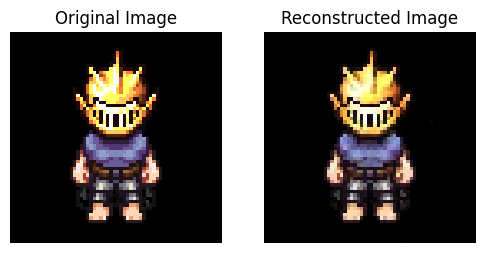

In [130]:
import matplotlib.pyplot as plt

TinyHero0.eval()

with torch.inference_mode():
    for i, (X, _) in enumerate(img_loader):
        X = X.to(device)
        y_pred = TinyHero0(X)

        # mean and std for un-normalizing
        mean = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1).to(device)
        std = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1).to(device)

        # un-normalize both input and output
        original_img = X * std + mean
        reconstructed_img = y_pred * std + mean

        # move to cpu and change shape to HWC
        original_img = original_img[0].cpu().permute(1, 2, 0).clamp(0, 1)
        reconstructed_img = reconstructed_img[0].cpu().permute(1, 2, 0).clamp(0, 1)

        print("original:", original_img.shape, "reconstructed:", reconstructed_img.shape)

        fig, ax = plt.subplots(1, 2, figsize=(6, 3))
        ax[0].imshow(original_img)
        ax[0].set_title("Original Image")
        ax[0].axis("off")
        ax[1].imshow(reconstructed_img)
        ax[1].set_title("Reconstructed Image")
        ax[1].axis("off")
        plt.show()
        break

# **Model 0 - Convulsional AutoEncoder Baseline Model**

**Results of the Training Session**
 * Loss function used: `MLELoss()`
 * Optimezer: Adam
 * Without *Data Augmentation*
 * Epochs: 50

# On CPU:

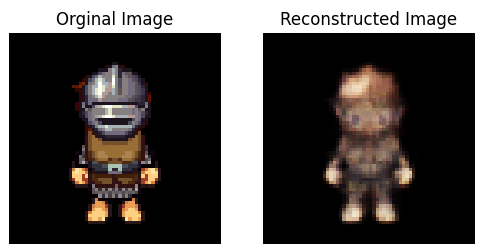

# On GPU:
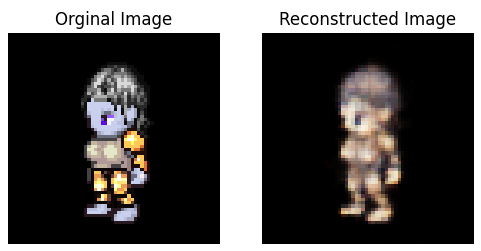

# 5 Epochs Results

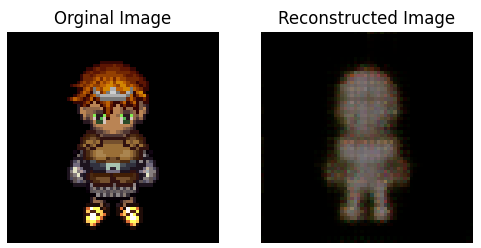

# **Model 0 - Training Time on CPU/GPU**

**Training Time on CPU**


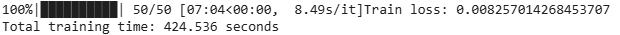

**Training Time on GPU**

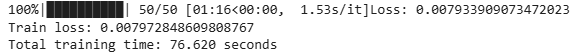

# Improving Model 0

* Applying Data Augmentation to the dataset
* Will change the Loss Function - `L1Loss`

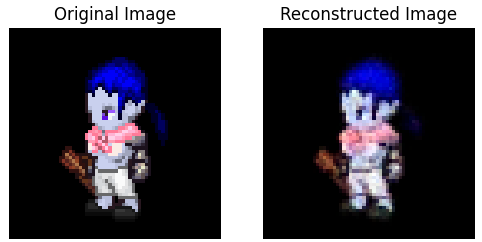



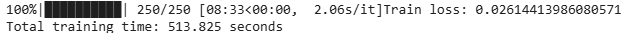

# Sobel Edge Filter - After the first 250 Epochs


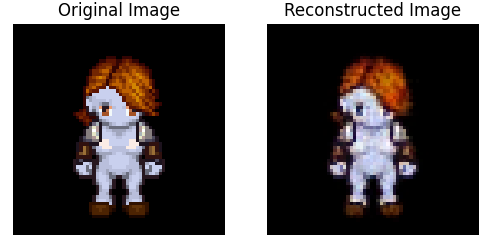



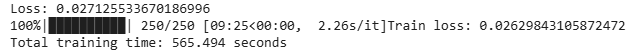


# Another 250 Epochs
 * we obtained a 0.0188 loss


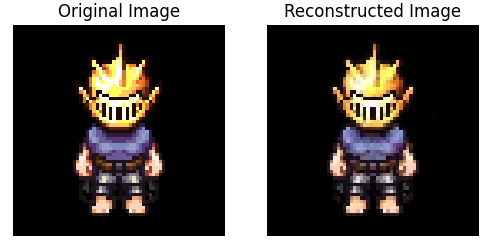


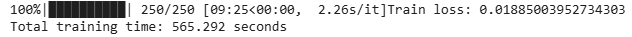

In [4]:
from pathlib import Path

MODEL_PATH = Path('Models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "pixelart_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=TinyHero0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: Models/pixelart_model.pth


NameError: name 'torch' is not defined

In [5]:
import torch
tiny_hero = TinyHero0()

state_dict = torch.load(MODEL_SAVE_PATH)
tiny_hero.load_state_dict(state_dict)

FileNotFoundError: [Errno 2] No such file or directory: 'Models/pixelart_model.pth'